In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

#### choose correct comparison groups

In [2]:
comparison_X = 'ATB_v_LTBI'

import packages

In [3]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier

import networkx as nx
import networkx.algorithms.community as nxcom
import community
from collections import Counter
import pickle
from collections import defaultdict

import gseapy as gp
import warnings
warnings.filterwarnings('ignore')

#### set parameters for plotting

In [4]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

#### specify directory paths

In [5]:
# use these paths for O2 computing cluster

#specify directory for Data
Data_files_dir = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/'

#specify directory for pickling objects
pickled_objects_dir = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Pickled Files/'

#specify directory for CSV files
CSV_files_dir = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/CSV Files/'

#specify directory for Gene Set Files
Gene_Set_dir = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Gene Set Files/CSV files/'

# [1] Load Data

### Network

In [6]:
G = nx.read_gpickle(pickled_objects_dir + f'Network Files/networks/{comparison_X}.pkl')

In [7]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2670
Number of edges: 683108
Average degree: 511.6914


In [8]:
num_nodes_overall_network = int(len(G.nodes()))

### Weighted Degrees for Nodes (genes)

In [9]:
weighted_deg_series = pd.read_pickle(pickled_objects_dir + f'Network Files/weighted degree series/{comparison_X}.pkl')

In [10]:
np.shape(weighted_deg_series)

(2670,)

### Mean $log_2(Fold Change)$ for Nodes (genes)

In [11]:
mean_logFC_series = pd.read_pickle(pickled_objects_dir + f'Network Files/mean logFC network nodes series/{comparison_X}.pkl')

In [12]:
np.shape(mean_logFC_series)

(2670,)

### Compile into DataFrame

In [13]:
G_deg_logFC_df = pd.DataFrame(index = mean_logFC_series.index)
G_deg_logFC_df['mean_log2FC'] = mean_logFC_series.values
G_deg_logFC_df['weighted_degree'] = weighted_deg_series[mean_logFC_series.index].values

In [14]:
G_deg_logFC_df.head()

,mean_log2FC,weighted_degree
C1QB,2.055265,549.6250
SERPING1,2.013491,574.1875
FCGR1B,1.955971,624.0625
ANKRD22,1.907299,484.0625
FCGR1A,1.900241,501.4375


# [2] *Functions* for community detection

### Louvain algorithm

In [15]:
def run_louvain_alg(G, mod_only):
    
    '''
    name: Louvain
    nature: Modularity Optimization
    complexity: O(L) where N = nodes, L = edges, and L~N for sparse networks
    ref: V. D. Blondel, J.-L. Guillaume, R. Lambiotte, and E. Lefebvre. Fast unfolding of communities in large networks. J. Stat. Mech., 2008.
    '''

    # Starting with an initial partition of the graph and running the Louvain algorithm for Community Detection
    partition = community.best_partition(G, weight='weight')
    
    # Grouping dictionary keys by value
    communities = defaultdict(list)
    for key, val in sorted(partition.items()):
        communities[val].append(key)
    communities = list(communities.values())

    # Calculating modularity
    mod = nxcom.modularity(G, communities, weight='weight')

    if mod_only == True:
        
        return mod
        
    else:

        # Creating a dictionary like {community_number:list_of_participants}
        values=[partition.get(node) for node in G.nodes()]
        list_com=partition.values()
        dict_nodes={}

        # Populating the dictionary with items
        for each_item in partition.items():
            community_num=each_item[1]
            community_node=each_item[0]
            if community_num in dict_nodes:
                value=dict_nodes.get(community_num) + ' | ' + str(community_node)
                dict_nodes.update({community_num:value})
            else:
                dict_nodes.update({community_num:community_node})

        # Creating a dataframe from the dict
        community_df=pd.DataFrame.from_dict(dict_nodes, orient='index',columns=['Members'])
        community_df.index.rename('Community_Num' , inplace=True)
        num_comm_members = [len(comm_i_member_list.split(' | ')) for comm_i_member_list in community_df.Members]
        community_df.loc[: , 'Num_Members'] = num_comm_members
        community_df.sort_values(by = 'Num_Members' , ascending = False , inplace = True)
        community_df.reset_index(inplace = True , drop = True)

        # Calculating the total number of communities
        print("Modularity: ", mod)
        print("Total number of Communities =", np.shape(community_df)[0])

        return community_df

### Girvan-Newman algorithm

In [16]:
def run_girvan_alg(G, mod_only):
    
    '''
    name: Girvan-Newman
    nature: Hierarchical Divisive
    complexity: O(N^2) where N = nodes, L = edges, and L~N for sparse networks
    ref: M. Girvan and M.E.J. Newman. Community structure in social and biological networks. PNAS, 99:7821–7826, 2002.
    '''
    
    # Using the Girvan-Newman algorithm to create a Community Structure
    comp=nxcom.girvan_newman(G)

    # Creating a dictionary for the community number assocaited with each node
    com = 0
    thisdict={}

    # Populating the items of the dictionary
    for c in next(comp):
        thislist=sorted(c)
        for i in range(len(thislist)):
            if thislist[i] in thisdict:
                print('already found')
            else:
                thisdict.update({thislist[i]: com})
            i+=1
        com+=1

    # Grouping dictionary keys by value
    communities = defaultdict(list)
    for key, val in sorted(thisdict.items()):
        communities[val].append(key)
    communities = list(communities.values())
    
    # Calculating modularity
    mod = nxcom.modularity(G, communities, weight='weight')

    if mod_only == True:
        
        return mod
        
    else:

        values=[thisdict.get(node) for node in G.nodes()]

        # Creating a dictionary like 'Community num':'List of participants'
        dict_nodes={}
        for each_item in thisdict.items():
            community_num=each_item[1]
            community_node=each_item[0]

            if community_num in dict_nodes:
                value=dict_nodes.get(community_num) + ' | ' + str(community_node)
                dict_nodes.update({community_num: value})
            else:
                dict_nodes.update({community_num: community_node})

        # Creating the output file
        community_df=pd.DataFrame.from_dict(dict_nodes, orient='index',columns=['Members'])
        community_df.index.rename('Community Num', inplace=True)
        num_comm_members = [len(comm_i_member_list.split(' | ')) for comm_i_member_list in community_df.Members]
        community_df.loc[: , 'Num_Members'] = num_comm_members
        community_df.sort_values(by = 'Num_Members' , ascending = False , inplace = True)
        community_df.reset_index(inplace = True , drop = True)

        # Calculating the total number of communities
        print("Modularity:", mod)
        print("Total number of Communities =", np.shape(community_df)[0])
        
        return community_df

### Clauset-Newman-Moore algorithm

In [17]:
def run_clauset_alg(G, mod_only):
    
    '''
    name: Greedy Modularity (optimized)
    nature: Modularity Optimization
    complexity: O(L) where N = nodes, L = edges, and L~N for sparse networks
    ref: A. Clauset, M.E.J. Newman, and C. Moore. Finding community structure in very large networks. Physical Review E, 70:066111, 2004.
    '''

    # Using the Clauset-Newman-Moore algorithm to create a Community Structure
    communities = nxcom.greedy_modularity_communities(G, weight='weight')
    communities = [list(comm_i) for comm_i in communities] #convert from list of frozen sets to list of lists
    
    # Calculate the modularity
    mod = nxcom.modularity(G, communities, weight='weight')

    if mod_only == True:
        
        return mod
        
    else:
        
        # Creating a dictionary for the community number associated with each node
        com = 0
        thisdict = {}

        # Populating the items of the dictionary
        for comm_i in communities: #iterate through communities
            for node_i in comm_i: #iterate through nodes within community
                thisdict[node_i] = com
            #update community ID
            com += 1

        # Creating a dictionary like 'Community num':'List of participants'
        values=[thisdict.get(node) for node in G.nodes()]
        dict_nodes={}
        for each_item in thisdict.items():
            community_num=each_item[1]
            community_node=each_item[0]

            if community_num in dict_nodes:
                value=dict_nodes.get(community_num) + ' | ' + str(community_node)
                dict_nodes.update({community_num: value})
            else:
                dict_nodes.update({community_num: community_node})

        # Creating the output file
        community_df=pd.DataFrame.from_dict(dict_nodes, orient='index',columns=['Members'])
        community_df.index.rename('Community Num', inplace=True)
        num_comm_members = [len(comm_i_member_list.split(' | ')) for comm_i_member_list in community_df.Members]
        community_df.loc[: , 'Num_Members'] = num_comm_members
        community_df.sort_values(by = 'Num_Members' , ascending = False , inplace = True)
        community_df.reset_index(inplace = True , drop = True)

        # Calculation of number of communities
        print("Modularity:", mod)
        print("Total number of Communities =", np.shape(community_df)[0])
        
        return community_df

# [3] Get sub-network constructed from retaining only nodes with $mean(logFC) \ge 0.5$ & detect communities

## [3.1] Get most heavily weighted edges that pass optimal threshold & construct sub-graph

In [18]:
len(G_deg_logFC_df.mean_log2FC[abs(G_deg_logFC_df.mean_log2FC) >= 0.5].index)

306

In [19]:
#get the nodes in the network that pass the logFC threshold
nodes_high_abs_logFC_subset = list(G_deg_logFC_df.mean_log2FC[abs(G_deg_logFC_df.mean_log2FC) >= 0.5].index)

#get the SUBGRAPH induced by the most these nodes (correspond to genes with >> |logFC|)
S = G.subgraph(nodes_high_abs_logFC_subset)

In [20]:
print(nx.info(S))

Name: 
Type: Graph
Number of nodes: 306
Number of edges: 43533
Average degree: 284.5294


Use **Spring Layout** to set the positions of the nodes

In [21]:
pos = nx.spring_layout(S , weight = 'weight' , iterations = 350 , k = 4.5)

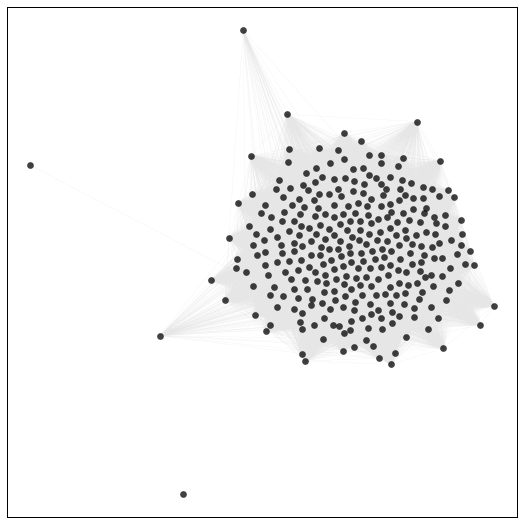

In [22]:
fig , ax = plt.subplots()

nx.draw_networkx(
    S, 
    pos = pos, 
    ax = ax,
    node_size = 45, 
    node_color = 'xkcd:black',
    linewidths = 0.0,
    edge_color = "0.9",
    width=0.25,
    alpha = 0.75, 
    with_labels = False)

fig = plt.gcf()
fig.set_size_inches(7.5, 7.5)
fig.tight_layout()
plt.show()

#### *Function* to retrieve node colors based of node values (i.e. weighted degree, logFC for gene)

In [23]:
def get_node_colors(node_values):
    
    '''
    This function takes a list of values for each node and color map, 
    normalizes the list of values from 0.0-1.0 and assigns each node 
    a color from a color map based on normalized values. Returns a 
    list of colors for nodes.
    '''
    color_map = []
    color_scheme = plt.get_cmap('bwr')
    node_values_normalized = (node_values-min(node_values))/(max(node_values) - min(node_values)) #normalize data

    for node_value in node_values_normalized:
        color_map.append(color_scheme(node_value))
        
    return color_map

#### *Function* to visualize network by weighted degree & logFC based on gene values

In [24]:
def visualize_network_color_by_weighted_deg_and_logFC(G, pos):
    
    #weighted degree for nodes in this network
    node_weighted_deg_values = G_deg_logFC_df.weighted_degree[list(G.nodes)] 
    
    #logFC for nodes in this network
    node_logFC_values = G_deg_logFC_df.mean_log2FC[list(G.nodes)] 
    
    fig = plt.figure(constrained_layout=True)

    gs = GridSpec(1, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    #color nodes by weighted deg
    nx.draw_networkx(
        G, 
        pos = pos, 
        ax = ax1,
        node_size = 40, 
        node_color = get_node_colors(node_weighted_deg_values),
        linewidths = 0.0,
        edge_color = "0.83",
        width=0.1,
        alpha = 1.0, 
        with_labels = False)
    
    ax1.set_title(f'Nodes colored by Weighted Deg (blue -> red)', fontsize = 14, color = 'k')
    
    #color nodes by logFC
    nx.draw_networkx(
        G, 
        pos = pos, 
        ax = ax2,
        node_size = 40, 
        node_color = get_node_colors(node_logFC_values),
        linewidths = 0.0,
        edge_color = "0.83",
        width=0.1,
        alpha = 1.0, 
        with_labels = False)
    
    ax2.set_title(f'Nodes colored by mean logFC (blue -> red)', fontsize = 14, color = 'k')

    ################### Plot
    fig = plt.gcf()
    fig.set_size_inches(15.0, 7.5)
    fig.tight_layout()

    #file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
    #plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

    plt.show()

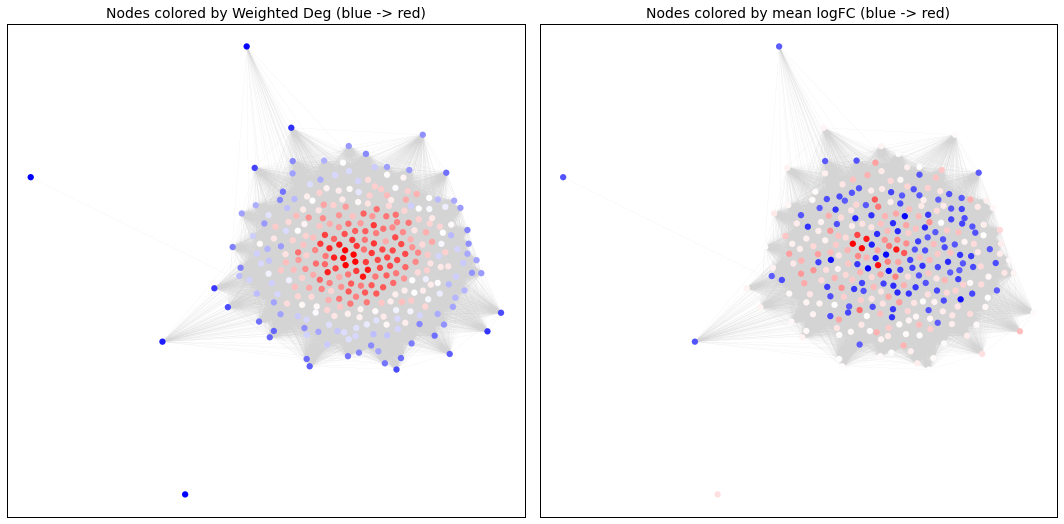

In [25]:
visualize_network_color_by_weighted_deg_and_logFC(S, pos)

## [3.2] Run community detection algorithms and check to see which yields the highest modularity

In [26]:
#run algorithms for COMMUNITY detection and return MODULARITY
mod_louvain = run_louvain_alg(S, True)
mod_girvan = run_girvan_alg(S, True)
mod_clauset = run_clauset_alg(S, True)

In [27]:
mod_louvain

0.03622794922483504

In [28]:
mod_girvan

4.781045541092831e-05

In [29]:
mod_clauset

2.3905620606504123e-05

### Run *Louvain* algorithm on sub-network and return communities

In [30]:
community_df = run_louvain_alg(S, False)

Modularity:  0.037182537564848066
Total number of Communities = 4


In [31]:
community_df

,Members,Num_Members
0,IFI44 | MYOF | IFI44L | LOC100419583 | CNIH4 |...,121
1,CASP1 | ASGR2 | ATOX1 | STK3 | GPR183 | CREB5 ...,97
2,DEFA1B | CASP5 | CXCR3 | NT5E | PRKCH | SIPA1L...,87
3,TSPAN15,1


## [3.3] Visualize communites within sub-network

#### *Function* to color a subset of nodes differently

In [32]:
def draw_graph_and_color_subset_nodes(G, nodes_in_group, ax):

    '''
    This function takes in a graph, list of a subset of nodes and axis object,
    then draws the network with the subset of nodes colored seperately from the 
    rest of the nodes in the network
    '''

    #draw nodes NOT in the (subset) group
    size_map = []
    for node in G:
        if node not in nodes_in_group:
            size_map.append(35)
        elif node in nodes_in_group:
            size_map.append(0)

    nx.draw_networkx(
        G, 
        ax = ax,
        pos=pos, 
        node_size=size_map, 
        node_color = "0.8",
        linewidths = 0.0,
        edge_color="0.7",
        width=0.0,
        alpha=1.0, 
        with_labels=False)

    #draw nodes that ARE in the (subset) group
    size_map = []
    for node in G:
        if node not in nodes_in_group:
            size_map.append(0)
        elif node in nodes_in_group:
            size_map.append(35)

    nx.draw_networkx(
        G, 
        pos=pos, 
        ax = ax,
        node_size=size_map, 
        node_color = 'xkcd:black',
        linewidths = 0.0,
        edge_color="0.7",
        width=0.0,
        alpha=1.0, 
        with_labels=False)

#### *Function* to plot a set of genes in within community

In [33]:
def draw_community_subgraph_network(G, comm_i):
    
    fig = plt.figure(constrained_layout=True)

    gs = GridSpec(1, 1, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    
    ################### VISUALIZE COMMUNITY ###################
    #get the set of nodes within the community
    nodes_in_community = set(community_df.loc[comm_i, 'Members'].split(' | '))
    number_of_nodes = len(nodes_in_community)

    #get the subgraph generated by nodes in community
    G_community_subgraph = G.subgraph(list(nodes_in_community)) 

    #draw the network & color the community differently
    draw_graph_and_color_subset_nodes(G, nodes_in_community, ax1)
    
    ax1.set_title(f'Community {comm_i} with {number_of_nodes} members', fontsize = 12, color = 'k')

    ################### Plot ###################
    fig = plt.gcf()
    fig.set_size_inches(7.5, 7.5)
    fig.tight_layout()

    #file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
    #plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

    plt.show()

### Visualize different communities

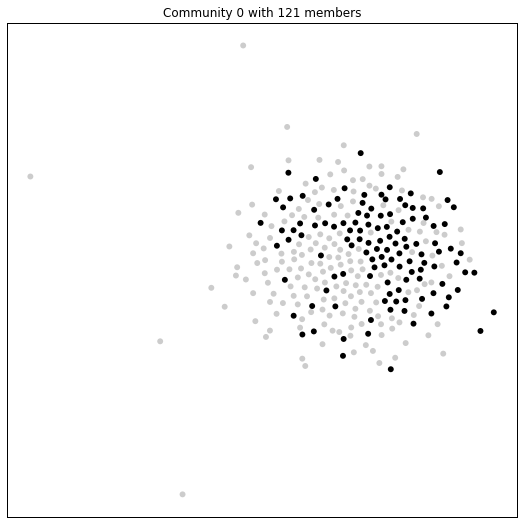

In [34]:
draw_community_subgraph_network(S, 0)

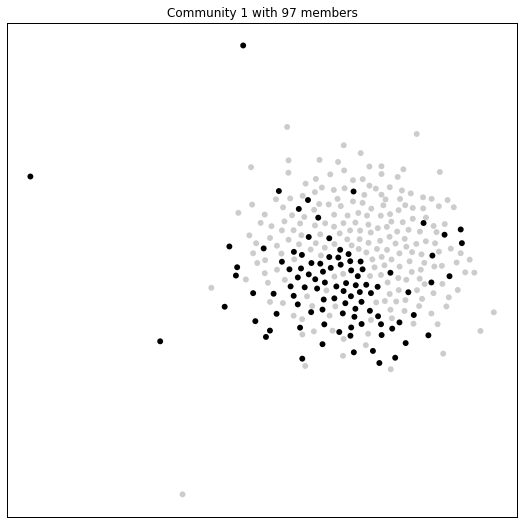

In [35]:
draw_community_subgraph_network(S, 1)

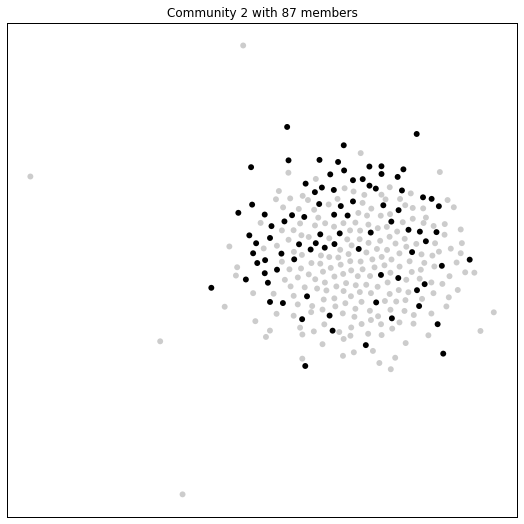

In [36]:
draw_community_subgraph_network(S, 2)

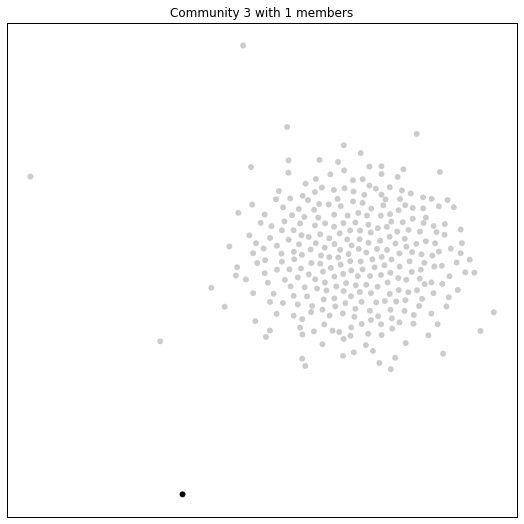

In [37]:
draw_community_subgraph_network(S, 3)

## [3.4] Run gene-enrichment analysis on genes within communities

### Load and prepare gene sets

DataFrame for the Gene Sets (excel files from Wen-Han)

In [38]:
GeneSets_df = pd.read_csv(f'{Gene_Set_dir}GeneModule.csv')

#subset to the first 298 modules (immune-related modules)
GeneSets_df = GeneSets_df.loc[0:297, :]

In [39]:
GeneSets_df.head()

,ID,Title,Category,B
0,LI.M0,targets of FOSL1/2,TF targets,12
1,LI.M1.0,integrin cell surface interactions (I),molecular function,29
2,LI.M1.1,integrin cell surface interactions (II),molecular function,12
3,LI.M2.0,extracellular matrix (I),location,30
4,LI.M2.1,extracellular matrix (II),location,45


In [40]:
np.shape(GeneSets_df)

(298, 4)

DataFrame for the genes that belong to each Gene Set

In [41]:
GeneSet_GeneLists_df = pd.read_csv(f'{Gene_Set_dir}GeneModule_Genelist.csv')
GeneSet_GeneLists_df.set_index('ID', drop = True, inplace = True)

In [42]:
GeneSet_GeneLists_df.head()

,Gene
ID,
LI.M0,CCL2
LI.M0,DCN
LI.M0,LIF
LI.M0,PLAU
LI.M0,IL6


In [43]:
np.shape(GeneSet_GeneLists_df)

(84042, 1)

#### Convert gene sets to a dictionary 
- keys: gene sets
- values: list of genes belonging to each set

In [44]:
gene_set_dict = {}
for gene_set_i in GeneSets_df.ID:
    gene_list_for_set_i = list(GeneSet_GeneLists_df[GeneSet_GeneLists_df.index == gene_set_i].Gene)
    
    if gene_list_for_set_i == []:
        print(gene_set_i)
    
    gene_set_dict[gene_set_i] = gene_list_for_set_i

In [45]:
len(gene_set_dict.keys()) #number of gene sets

298

#### *Function* to run gene set enrichment

In [46]:
def run_enrichr_on_list_of_genes(gene_list):
    
    #run enrichr
    enr = gp.enrichr(gene_list = gene_list,  
        gene_sets = gene_set_dict,
        background = 'hsapiens_gene_ensembl',
        organism = 'Human',
        description = f'community pathway enrichment',
        outdir = f'{Data_files_dir}/enrichr gene set analyses bucket',
        no_plot = True)

    #filter & sort enrichr results df
    enrichr_results_df = enr.results
    enrichr_results_df = enrichr_results_df.loc[: , ['Term', 'P-value', 'Adjusted P-value', 'Overlap', 'Genes']] #subset to necessary columns
    enrichr_results_df.rename(columns = {'Term':'ID'}, inplace = True) #rename column for merging with Gene Set df
    enrichr_results_df = enrichr_results_df[enrichr_results_df.loc[: , 'Adjusted P-value'] <= 0.001] #keep hits with lowest adj. p-vals
    enrichr_results_df.sort_values(by = 'Adjusted P-value', ascending = True , inplace = True) #sort by lowest p-val
    enrichr_results_df.reset_index(inplace = True, drop = True) #reset index
    enrichr_results_df = enrichr_results_df.merge(GeneSets_df.loc[: , ['ID','Title','Category']], how = 'left', on = 'ID') #get details for gene sets
    
    return enrichr_results_df

### Run gene set enrichment on genes detected within different communities

Community 0

In [47]:
community_i = 0
community_node_list = community_df.loc[community_i,'Members'].split(' | ') #get list of genes that belong to the community
run_enrichr_on_list_of_genes(community_node_list) #pathway enrichment

,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,DC.M4.15,3.668648e-25,3.375156e-23,16/42,CD247;GZMK;ITK;LBH;NMT2;CD5;DYRK2;BIN1;RASGRP1...,T cells,DC.M4
1,LI.M7.0,3.293845e-20,1.515169e-18,15/62,CD247;RORA;ITK;ETS1;GZMK;EOMES;RASGRP1;CD2;CD3...,enriched in T cells (I),immune
2,DC.M3.4,5.316312e-16,1.630336e-14,12/53,PARP9;GBP1;AIM2;WARS;PARP14;CARD17;CEACAM1;SAM...,Interferon,DC.M3
3,LI.M7.1,6.100595e-13,1.403137e-11,10/50,CD247;RORA;ITK;CD5;EOMES;RASGRP1;CD2;CD3G;CD27...,T cell activation (I),immune
4,LI.M7.4,2.166124e-12,3.985668e-11,7/15,RORA;ETS1;RASGRP1;ATP8B2;KLF12;CD96;NELL2,T cell activation (III),immune
5,LI.M37.0,7.366553e-12,1.129538e-10,18/347,SIGLEC5;BANK1;CD2;QPCT;CD19;KCNJ15;CEACAM1;CLE...,immune activation - generic cluster,immune
6,LI.M7.2,2.073917e-11,2.725720e-10,9/49,CD247;RORA;ITK;EOMES;PLEKHF1;ZAP70;TGFBR3;CD96...,enriched in NK cells (I),immune
7,DC.M1.2,2.806679e-10,3.227681e-09,7/27,IFI44;OAS1;IFI44L;RSAD2;OASL;ISG15;IFIT3,Interferon,DC.M1
8,LI.M7.3,3.758024e-08,3.841536e-07,6/31,CD247;ITK;CD3G;ZAP70;PTPRCAP;IL18R1,T cell activation (II),immune
9,DC.M3.2,2.412329e-07,2.219343e-06,9/138,SIGLEC5;ZNF438;TLR4;QPCT;KCNJ15;USB1;SLC22A4;R...,Inflammation,DC.M3


Community 1

In [48]:
community_i = 1
community_node_list = community_df.loc[community_i,'Members'].split(' | ') #get list of genes that belong to the community
run_enrichr_on_list_of_genes(community_node_list) #pathway enrichment

,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,LI.M11.0,1.837403e-15,1.653663e-13,16/189,FAM198B;MEGF9;CYBB;HK3;RAB32;PLBD1;ASGR2;SORT1...,enriched in monocytes (II),immune
1,LI.M37.0,1.838796e-12,8.274580e-11,17/347,MEGF9;HK3;PRRG4;CREB5;RAB32;MARC1;CAMP;F5;SH2D...,immune activation - generic cluster,immune
2,DC.M4.1,1.370895e-11,4.112684e-10,9/58,GPR183;SLC16A10;CCR7;SPOCK2;IL7R;ICOS;ID3;FAM1...,T cell,DC.M4
3,LI.S4,4.652360e-11,1.046781e-09,10/94,AGTRAP;CCR2;CD36;ASGR2;MCTP1;DYSF;ASGR1;TLR5;F...,Monocyte surface signature,immune
4,DC.M3.4,2.481820e-10,4.467277e-09,8/53,FBXO6;IFI35;TNFSF10;SCO2;SEPT4;TRIM22;UBE2L6;LAP3,Interferon,DC.M3
5,LI.M118.0,1.535016e-08,2.302524e-07,7/57,NAIP;MARC1;SMARCD3;DYSF;LRRK2;F5;LTBR,enriched in monocytes (IV),immune
6,DC.M3.2,5.215163e-07,6.705209e-06,8/138,MEGF9;CREB5;LTB4R;TSHZ3;DYSF;F5;GNG10;SULT1B1,Inflammation,DC.M3
7,LI.M109,8.273882e-07,9.308117e-06,4/15,CCR7;S1PR1;CCR2;LRRK2,"receptors, cell migration",molecular function
8,LI.M4.0,1.096584e-06,1.096584e-05,11/335,FAM198B;CYBB;PLBD1;ASGR2;SORT1;S100A12;ASGR1;F...,cell cycle and transcription,biological process
9,LI.M16,3.592213e-06,3.232991e-05,5/46,DYSF;FCGR1A;TLR5;LILRA6;FCGR1B,TLR and inflammatory signaling,immune


Community 2

In [49]:
community_i = 2
community_node_list = community_df.loc[community_i,'Members'].split(' | ') #get list of genes that belong to the community
run_enrichr_on_list_of_genes(community_node_list) #pathway enrichment

,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,LI.M37.0,8.812147e-25,6.697232e-23,26/347,HP;CEACAM6;CCR9;OLFM4;ACSL1;SLPI;LTF;CLEC12A;C...,immune activation - generic cluster,immune
1,DC.M4.2,2.456168e-22,9.333437e-21,14/48,SOCS3;CASP5;KREMEN1;IRAK3;ANXA3;CYSTM1;PGLYRP1...,Inflammation,DC.M4
2,DC.M5.15,2.533248e-18,6.417561e-17,10/23,HP;CEACAM6;ELANE;DEFA4;BPI;TCN1;CEACAM8;ARG1;L...,Neutrophils,DC.M5
3,DC.M4.1,8.095796e-09,1.538201e-07,7/58,ABLIM1;BACH2;LRRN3;LEF1;EPHA4;PASK;TMEM204,T cell,DC.M4
4,LI.M112.0,1.050481e-08,1.596731e-07,5/17,C1QC;SERPING1;C2;C1QB;C1QA,complement activation (I),immune
5,LI.M40,2.816751e-07,3.567884e-06,4/13,C1QB;C1QA;LY96;C1QC,complement and other receptors in DCs,immune
6,LI.M75,2.792660e-06,3.032031e-05,4/22,SERPING1;ANXA3;ELANE;C1QB,antiviral IFN signature,immune
7,LI.M67,1.967487e-05,1.869113e-04,3/12,SERPING1;C2;C1QC,activated dendritic cells,immune
8,LI.M11.0,2.540384e-05,2.145213e-04,7/189,HPSE;SECTM1;IRAK3;CRISPLD2;S100A8;NOD2;CLEC4E,enriched in monocytes (II),immune
9,LI.M140,3.233825e-05,2.457707e-04,3/14,CRISPLD2;SLPI;MMP8,"extracellular matrix, complement",location


Community 3

In [50]:
community_i = 3
community_node_list = community_df.loc[community_i,'Members'].split(' | ') #get list of genes that belong to the community
run_enrichr_on_list_of_genes(community_node_list) #pathway enrichment

,P-value,Adjusted P-value,Overlap,Genes,ID,Title,Category


## [4] Calculate *mean edge weight*, *mean weighted degree*, *num edges*, *num nodes* & *community modularities* for subgraphs induced by highest weighted edges

### Edges Weights for Node Pairs (gene pairs)

In [51]:
edge_weight_dict = nx.get_edge_attributes(G, 'weight') #keys: node pairs; values: edge weights
edge_weight_array = np.array(list(edge_weight_dict.values())) #array of edge weights in graph

In [52]:
len(edge_weight_array)

683108

In [53]:
edge_weight_array.mean()

0.2237516798222243

### Distribution of Edge Weights in original Network

In [54]:
def prettify_plot(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

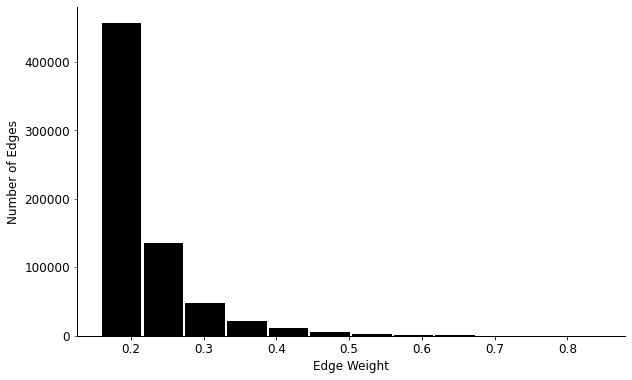

In [55]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(1, 1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])

#EDGE WEIGHTS
ax1.hist(edge_weight_array , bins = len(set(edge_weight_array)), color = 'black' , rwidth = 0.95 , edgecolor='white', linewidth=0.0, align='left')

ax1.set_ylabel('Number of Edges', fontsize = 12, color = 'k')
ax1.set_xlabel('Edge Weight' , fontsize = 12, color = 'k')

prettify_plot(ax1)
#ax1.set_yscale('log')
    
################### Plot ###################
fig = plt.gcf()
fig.set_size_inches(9, 5.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [56]:
edge_weight_thresholds = np.sort(np.array(list(set(edge_weight_array))))
edge_weight_thresholds

array([0.1875, 0.25  , 0.3125, 0.375 , 0.4375, 0.5   , 0.5625, 0.625 ,
       0.6875, 0.75  , 0.8125, 0.875 ])

The last edge weight only occurs for **one** node, so we will omit from analysis

In [59]:
edge_weight_dict_subset = {key:value for key, value in edge_weight_dict.items() if value >= 0.875}
edge_weight_array_subset = np.array(list(edge_weight_dict_subset.values()))

#get the SUBGRAPH induced by the most heavily weighted edges
G_mod = G.edge_subgraph(list(edge_weight_dict_subset.keys()))

print(nx.info(G_mod))

Name: 
Type: Graph
Number of nodes: 1
Number of edges: 1
Average degree:   2.0000


In [60]:
edge_weight_thresholds = edge_weight_thresholds[:-1]
edge_weight_thresholds

array([0.1875, 0.25  , 0.3125, 0.375 , 0.4375, 0.5   , 0.5625, 0.625 ,
       0.6875, 0.75  , 0.8125])

In [62]:
def get_characteristics_of_subgraph(edge_weight_thresh):
    
    '''
    (1) This function returns the mean (edge weight) & (weighted degree) of the subgraph induced by the edges 
    that pass the edge weight threshold in the larger network.
    
    (2) Function returns the (# Edges) and (# Nodes) for these different subgraphs.
    
    (3) Function also returns the modularity after running a community detection
    algorithm on the subgraph
    '''
    
    #get the EDGE WEIGHTS for edges in the network that pass the edge weight threshold
    edge_weight_dict_subset = {key:value for key, value in edge_weight_dict.items() if value >= edge_weight_thresh}
    edge_weight_array_subset = np.array(list(edge_weight_dict_subset.values()))

    #get the SUBGRAPH induced by the most heavily weighted edges
    S = G.edge_subgraph(list(edge_weight_dict_subset.keys()))

    #Get a series of the WEIGHTED DEGREE for each node in the subgraph 
    node_list = [node_deg[0] for node_deg in list(S.degree(weight = 'weight'))]
    degree_list = [node_deg[1] for node_deg in list(S.degree(weight = 'weight'))]
    subgraph_weighted_degree_series = pd.Series(degree_list , index = node_list).sort_values(ascending = False)
    
    #run algorithms for COMMUNITY detection and return MODULARITY
    mod_louvain = run_louvain_alg(S, True)
    mod_girvan = run_girvan_alg(S, True)
    mod_clauset = run_clauset_alg(S, True)
    
    return [edge_weight_array_subset.mean() , subgraph_weighted_degree_series.mean() , float(len(edge_weight_array_subset)) , float(len(node_list)) , mod_louvain, mod_girvan, mod_clauset]

#### Iterate through subnetworks of various sizes for different *edge weight thresholds* in original network

In [63]:
mean_edge_weight_for_subnetworks_list = []
mean_weighted_deg_for_subnetworks_list = []
num_edges_for_subnetworks_list = []
num_nodes_for_subnetworks_list = []
louvain_modularity_for_subnetworks_list = []
girvan_modularity_for_subnetworks_list = []
clauset_modularity_for_subnetworks_list = []

for edge_weight_thresh in edge_weight_thresholds:
    
    subgraph_mean_edge_weight , subgraph_mean_weighted_deg , subgraph_num_edges , subgraph_num_nodes , subgraph_comm_mod_louvain , subgraph_comm_mod_girvan , subgraph_comm_mod_clauset = get_characteristics_of_subgraph(edge_weight_thresh)
    
    mean_edge_weight_for_subnetworks_list.append(subgraph_mean_edge_weight)
    mean_weighted_deg_for_subnetworks_list.append(subgraph_mean_weighted_deg)
    num_edges_for_subnetworks_list.append(subgraph_num_edges)
    num_nodes_for_subnetworks_list.append(subgraph_num_nodes)
    louvain_modularity_for_subnetworks_list.append(subgraph_comm_mod_louvain)
    girvan_modularity_for_subnetworks_list.append(subgraph_comm_mod_girvan)
    clauset_modularity_for_subnetworks_list.append(subgraph_comm_mod_clauset)
    
    print(edge_weight_thresh)
    
#convert to arrays
mean_edge_weight_for_subnetworks = np.array(mean_edge_weight_for_subnetworks_list)
mean_weighted_deg_for_subnetworks = np.array(mean_weighted_deg_for_subnetworks_list)
num_edges_for_subnetworks = np.array(num_edges_for_subnetworks_list)
num_nodes_for_subnetworks = np.array(num_nodes_for_subnetworks_list)
louvain_modularity_for_subnetworks = np.array(louvain_modularity_for_subnetworks_list)
girvan_modularity_for_subnetworks = np.array(girvan_modularity_for_subnetworks_list)
clauset_modularity_for_subnetworks = np.array(clauset_modularity_for_subnetworks_list)

0.1875
0.25
0.3125
0.375
0.4375
0.5
0.5625
0.625
0.6875
0.75
0.8125


#### Plot various characteristics of subgraphs induced by highest weighted edges

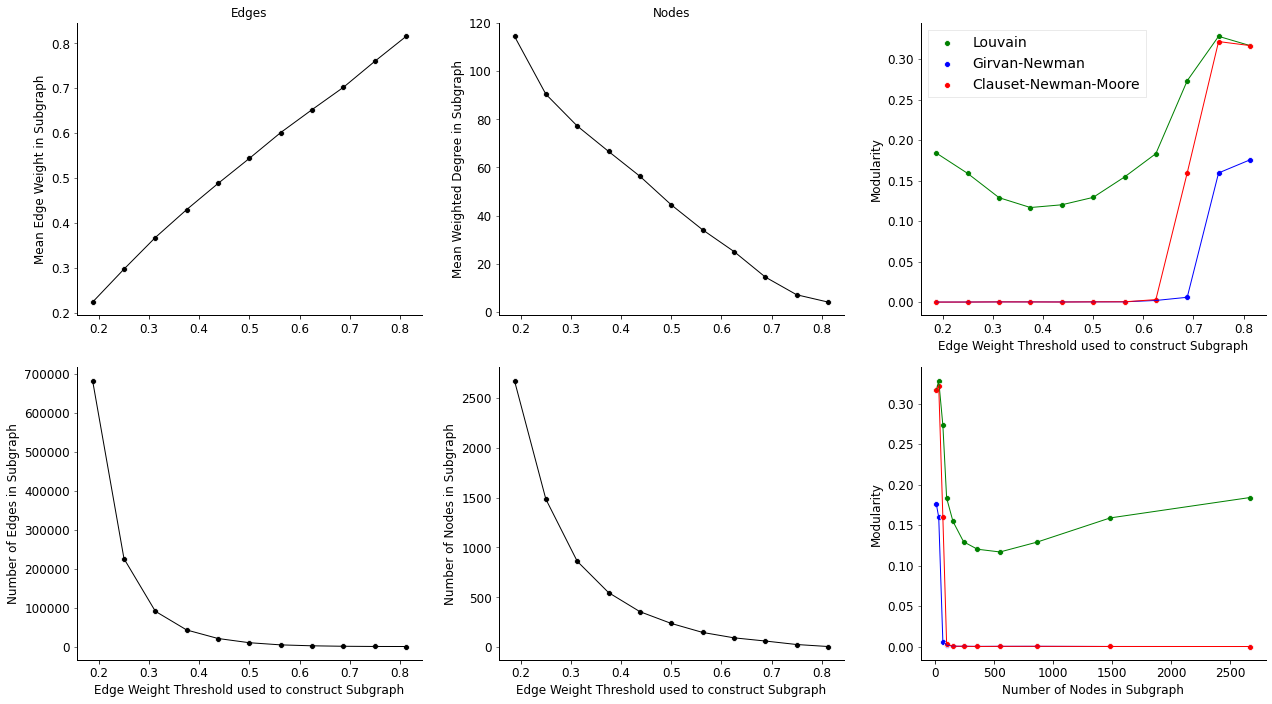

In [64]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])

#EDGE WEIGHT
ax1.scatter(edge_weight_thresholds, mean_edge_weight_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax1.plot(edge_weight_thresholds, mean_edge_weight_for_subnetworks , color = 'black' , linewidth=1.0)

ax1.set_ylabel('Mean Edge Weight in Subgraph', fontsize = 12, color = 'k')
ax1.set_title('Edges', fontsize = 12, color = 'k')

prettify_plot(ax1)
    
#WEIGHTED DEGREE
ax2.scatter(edge_weight_thresholds, mean_weighted_deg_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax2.plot(edge_weight_thresholds, mean_weighted_deg_for_subnetworks , color = 'black' , linewidth=1.0)

ax2.set_ylabel('Mean Weighted Degree in Subgraph', fontsize = 12, color = 'k')
ax2.set_title('Nodes', fontsize = 12, color = 'k')

prettify_plot(ax2)

#NUMBER OF EDGES
ax3.scatter(edge_weight_thresholds, num_edges_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax3.plot(edge_weight_thresholds, num_edges_for_subnetworks , color = 'black' , linewidth=1.0)

ax3.set_ylabel('Number of Edges in Subgraph', fontsize = 12, color = 'k')
ax3.set_xlabel('Edge Weight Threshold used to construct Subgraph' , fontsize = 12, color = 'k')

prettify_plot(ax3)

#NUMBER OF NODES
ax4.scatter(edge_weight_thresholds, num_nodes_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax4.plot(edge_weight_thresholds, num_nodes_for_subnetworks , color = 'black' , linewidth=1.0)

ax4.set_ylabel('Number of Nodes in Subgraph', fontsize = 12, color = 'k')
ax4.set_xlabel('Edge Weight Threshold used to construct Subgraph' , fontsize = 12, color = 'k')

prettify_plot(ax4)

#MODULARITY
#for communities detected in subnetworks using Lovain, Girvan-Newman, Clauset-Newman-Moore Algorithms
ax5.scatter(edge_weight_thresholds, louvain_modularity_for_subnetworks , color = 'green' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0, label = 'Louvain')
ax5.plot(edge_weight_thresholds, louvain_modularity_for_subnetworks , color = 'green' , linewidth=1.0)

ax5.scatter(edge_weight_thresholds, girvan_modularity_for_subnetworks , color = 'blue' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0 , label = 'Girvan-Newman')
ax5.plot(edge_weight_thresholds, girvan_modularity_for_subnetworks , color = 'blue' , linewidth=1.0)

ax5.scatter(edge_weight_thresholds, clauset_modularity_for_subnetworks , color = 'red' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0 , label = 'Clauset-Newman-Moore')
ax5.plot(edge_weight_thresholds, clauset_modularity_for_subnetworks , color = 'red' , linewidth=1.0)

ax5.set_ylabel('Modularity', fontsize = 12, color = 'k')
ax5.set_xlabel('Edge Weight Threshold used to construct Subgraph' , fontsize = 12, color = 'k')
#ax5.set_title('Communities detected from Lovain Algorithm', fontsize = 12, color = 'k')
ax5.legend(loc="upper left", fancybox = False)

prettify_plot(ax5)

#MODULARITY v. NUMBER OF NODES
ax6.scatter(num_nodes_for_subnetworks , louvain_modularity_for_subnetworks, color = 'green' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax6.plot(num_nodes_for_subnetworks , louvain_modularity_for_subnetworks, color = 'green' , linewidth=1.0)

ax6.scatter(num_nodes_for_subnetworks , girvan_modularity_for_subnetworks, color = 'blue' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax6.plot(num_nodes_for_subnetworks , girvan_modularity_for_subnetworks, color = 'blue' , linewidth=1.0)

ax6.scatter(num_nodes_for_subnetworks , clauset_modularity_for_subnetworks, color = 'red' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax6.plot(num_nodes_for_subnetworks , clauset_modularity_for_subnetworks, color = 'red' , linewidth=1.0)

ax6.set_ylabel('Modularity', fontsize = 12, color = 'k')
ax6.set_xlabel('Number of Nodes in Subgraph' , fontsize = 12, color = 'k')

prettify_plot(ax6)
    
################### Plot ###################
fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

## [5] Iterate through subnetworks constructed from most heavily weighted edges and preform gene enrichment analysis

### *Function* to plot subnetworks (after thresholding edge weights) & perform gene enrichment on nodes

In [65]:
def subgraph_visualize_and_gene_enrichment(edge_weight_thresh):
    
    '''
    (1) This function returns visualizes the sub-network generated by 
    retaining only the edge weights above the input edge weight threshold.
        (1.1) colors nodes by weighted degree
        (1.2) colors nodes by mean logFC
        
    (2) This function also returns a dataframe from the gene enrichment 
    analysis run on the nodes of the subnetwork.
    '''
    
    #get the EDGE WEIGHTS for edges in the network that pass the edge weight threshold
    edge_weight_dict_subset = {key:value for key, value in edge_weight_dict.items() if value >= edge_weight_thresh}
    edge_weight_array_subset = np.array(list(edge_weight_dict_subset.values()))

    #get the SUBGRAPH induced by the most heavily weighted edges
    S = G.edge_subgraph(list(edge_weight_dict_subset.keys()))
    
    #print some stats
    print('')
    print('')
    print('')
    print('')
    print(f'Edge Weight Threshold = {edge_weight_thresh}')
    print(f'Number of Nodes = {len(S.nodes)}')
    print('---------------------------------------------')
    
    #visualize subgraph
    pos = nx.spring_layout(S , weight = 'weight' , iterations = 350 , k = 1.75)
    visualize_network_color_by_weighted_deg_and_logFC(S, pos)
    
    #gene set enrichment
    gene_enrichr_df = run_enrichr_on_list_of_genes(list(S.nodes))
    print(f'gene enrichment for nodes in this network: ')
    display(gene_enrichr_df.head(n=40)) #return the top 40 hits if there are > 40
    print('---------------------------------------------')
    
    ## return gene_enrichr_df

### Iterate through subnetworks of various sizes for different *edge weight thresholds* in original network

In [66]:
for edge_weight_thresh_i, num_nodes_subnetwork_i in zip(edge_weight_thresholds, num_nodes_for_subnetworks):
    print(f'Edge Weight Threshold = {edge_weight_thresh_i} , Number of Nodes in Subnetwork = {num_nodes_subnetwork_i}')

Edge Weight Threshold = 0.1875 , Number of Nodes in Subnetwork = 2670.0
Edge Weight Threshold = 0.25 , Number of Nodes in Subnetwork = 1484.0
Edge Weight Threshold = 0.3125 , Number of Nodes in Subnetwork = 862.0
Edge Weight Threshold = 0.375 , Number of Nodes in Subnetwork = 548.0
Edge Weight Threshold = 0.4375 , Number of Nodes in Subnetwork = 357.0
Edge Weight Threshold = 0.5 , Number of Nodes in Subnetwork = 239.0
Edge Weight Threshold = 0.5625 , Number of Nodes in Subnetwork = 149.0
Edge Weight Threshold = 0.625 , Number of Nodes in Subnetwork = 95.0
Edge Weight Threshold = 0.6875 , Number of Nodes in Subnetwork = 63.0
Edge Weight Threshold = 0.75 , Number of Nodes in Subnetwork = 28.0
Edge Weight Threshold = 0.8125 , Number of Nodes in Subnetwork = 8.0


We're going to start with the smallest **edge weight threshold** and iterate down from there (increase edge weight threshold but decrease # of nodes) to preform gene enrichment





Edge Weight Threshold = 0.1875
Number of Nodes = 2670
---------------------------------------------


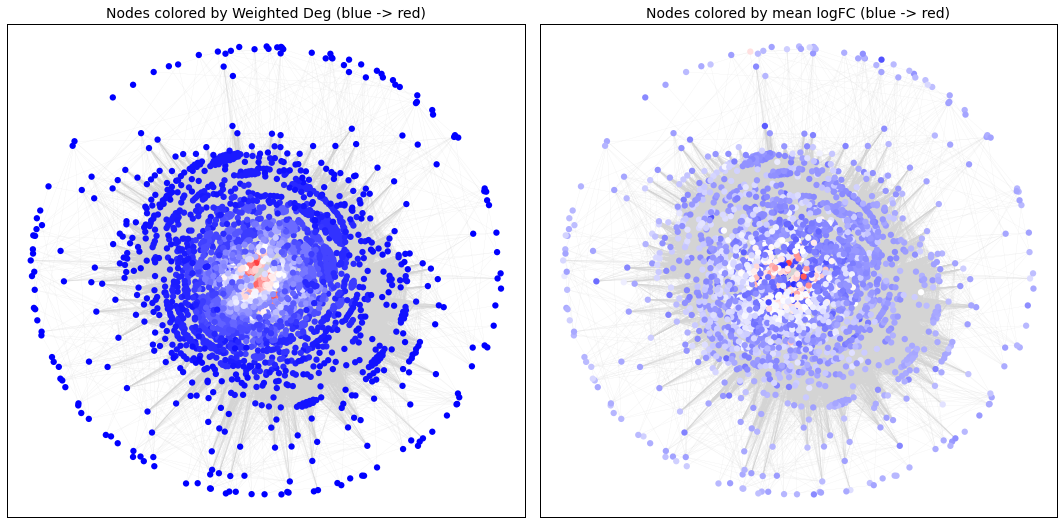

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,LI.M37.0,4.436009e-58,1.197722e-55,173/347,MGAM;PAX5;CYP4F3;PTGS2;NME8;KCNJ15;BST1;ROPN1L...,immune activation - generic cluster,immune
1,LI.M11.0,1.119665e-50,1.511548e-48,115/189,MYOF;ASGR2;RBM47;LMO2;BST1;ITGAM;MARCH1;CYP1B1...,enriched in monocytes (II),immune
2,DC.M3.2,1.328380e-44,1.195542e-42,91/138,CYP4F3;KCNJ15;BST1;ROPN1L;ITGAM;RGL4;FAR2;BASP...,Inflammation,DC.M3
3,DC.M4.1,9.443659e-32,6.374470e-30,48/58,STMN3;BCL2;NSG1;OXNAD1;DHRS3;SH3YL1;TESPA1;AXI...,T cell,DC.M4
4,DC.M4.7,1.368770e-30,7.391359e-29,64/100,RRN3;C12orf29;ANAPC1;MAP3K4;ESYT1;AKAP11;SMARC...,Cell Cycle,DC.M4
5,LI.M7.0,2.943507e-29,1.324578e-27,48/62,CD247;GZMM;GZMH;RASGRP1;TIGIT;SIRPG;ICOS;SIT1;...,enriched in T cells (I),immune
6,DC.M4.15,1.894530e-28,7.307472e-27,38/42,CD247;ARL4C;BIN1;RASGRP1;PLEKHA1;SIRPG;ZNF831;...,T cells,DC.M4
7,DC.M3.4,1.714700e-26,5.787113e-25,42/53,IRF7;TIMM10;IFIH1;DDX58;PLSCR1;FBXO6;GBP3;IFI3...,Interferon,DC.M3
8,LI.M37.1,9.824690e-26,2.947407e-24,41/52,GLT1D1;MGAM;CYP4F3;KCNJ15;FCGR3A;RGL4;STEAP4;B...,enriched in neutrophils (I),immune
9,LI.M7.1,1.396147e-25,3.769598e-24,40/50,CD247;RASGRP1;DPP4;TIGIT;SIRPG;ICOS;SIT1;TCF7;...,T cell activation (I),immune


---------------------------------------------




Edge Weight Threshold = 0.25
Number of Nodes = 1484
---------------------------------------------


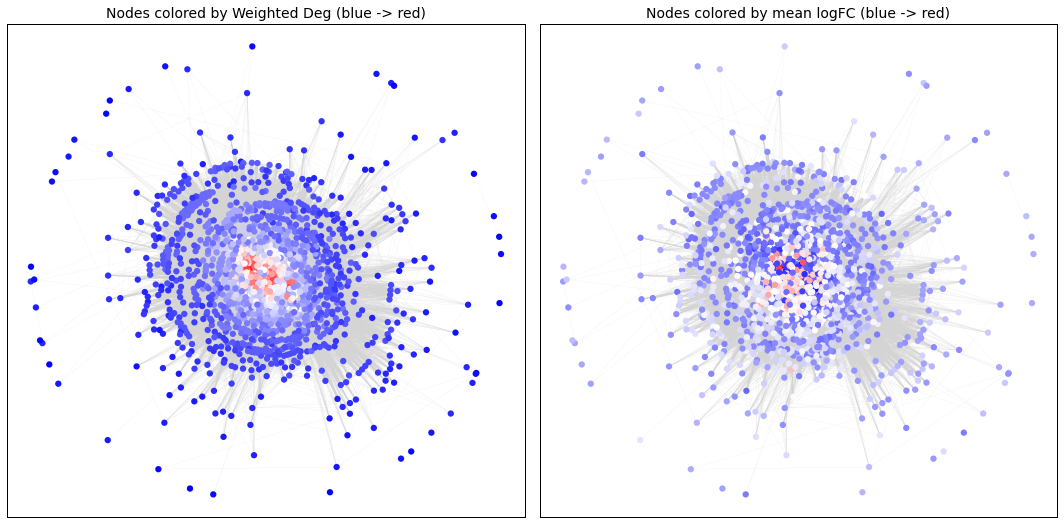

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,LI.M37.0,2.633063e-60,6.003384e-58,135/347,MGAM;CYP4F3;PTGS2;NME8;KCNJ15;BST1;ROPN1L;ITGA...,immune activation - generic cluster,immune
1,LI.M11.0,2.902779e-49,3.309168e-47,90/189,MYOF;ASGR2;RBM47;LMO2;BST1;ITGAM;MARCH1;CYP1B1...,enriched in monocytes (II),immune
2,DC.M3.2,1.515302e-46,1.151630e-44,75/138,SIGLEC5;TLR6;CYP4F3;LY96;GCA;TRIB1;KCNJ15;CKAP...,Inflammation,DC.M3
3,LI.M7.0,1.213989e-39,6.919735e-38,47/62,CD247;GZMM;RASGRP1;TIGIT;SIRPG;ICOS;SIT1;CD7;S...,enriched in T cells (I),immune
4,DC.M4.1,8.370668e-39,3.817024e-37,45/58,STMN3;BCL2;NSG1;OXNAD1;DHRS3;SH3YL1;TESPA1;AXI...,T cell,DC.M4
5,DC.M4.15,4.073405e-38,1.547894e-36,38/42,CD247;ARL4C;BIN1;RASGRP1;PLEKHA1;SIRPG;ZNF831;...,T cells,DC.M4
6,LI.M7.1,6.032440e-34,1.964852e-32,39/50,CD247;RASGRP1;DPP4;TIGIT;SIRPG;ICOS;SIT1;TCF7;...,T cell activation (I),immune
7,LI.M7.2,2.381261e-31,6.786595e-30,37/49,CD247;ARL4C;GZMM;FASLG;TBX21;SAMD3;PRKCH;CTSW;...,enriched in NK cells (I),immune
8,DC.M3.4,9.747903e-31,2.469469e-29,38/53,IRF7;TIMM10;IFIH1;DDX58;PLSCR1;FBXO6;IFI35;GBP...,Interferon,DC.M3
9,DC.M4.2,7.938935e-29,1.810077e-27,35/48,SAMSN1;MGAM;FKBP5;CASP5;LMNB1;WDFY3;SLPI;MAPK1...,Inflammation,DC.M4


---------------------------------------------




Edge Weight Threshold = 0.3125
Number of Nodes = 862
---------------------------------------------


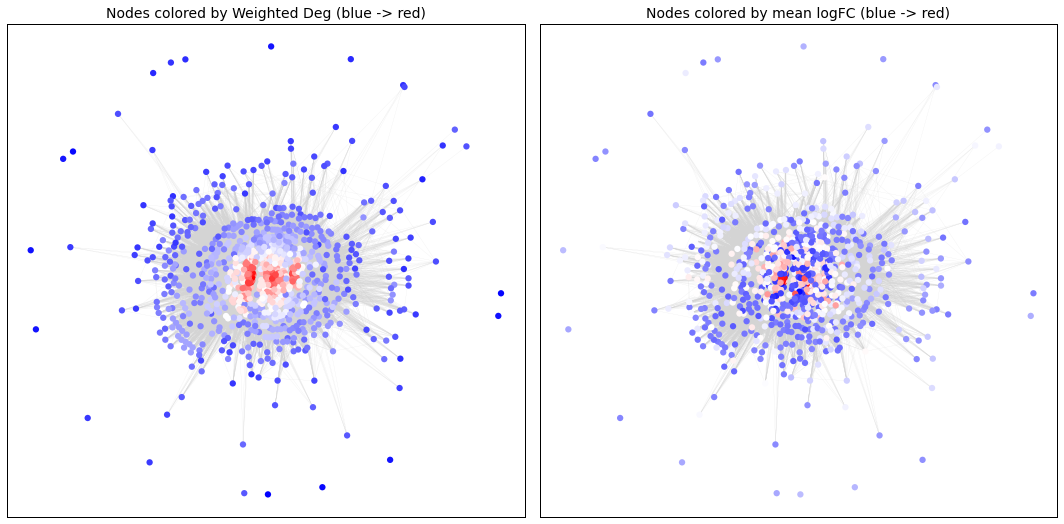

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,LI.M37.0,6.202685e-62,1.265348e-59,109/347,MGAM;CYP4F3;KCNJ15;BST1;ROPN1L;ITGAM;LTF;RGL4;...,immune activation - generic cluster,immune
1,LI.M11.0,7.085332e-41,7.227038e-39,66/189,TLR2;MYOF;HK3;ASGR2;GCA;FES;RBM47;FCER1G;LMO2;...,enriched in monocytes (II),immune
2,LI.M7.0,2.287906e-40,1.555776e-38,41/62,CD247;RASGRP1;TIGIT;SIRPG;ICOS;CD7;SAMD3;PRKCH...,enriched in T cells (I),immune
3,DC.M4.15,8.830289e-39,4.503447e-37,34/42,CD247;BIN1;RASGRP1;PLEKHA1;SIRPG;ZNF831;CD7;LY...,T cells,DC.M4
4,LI.M7.1,1.026460e-37,4.187958e-36,36/50,CD247;RASGRP1;DPP4;TIGIT;SIRPG;ICOS;TCF7;CD7;P...,T cell activation (I),immune
5,DC.M3.2,1.280292e-36,4.352992e-35,54/138,SIGLEC5;TLR6;CYP4F3;GCA;KCNJ15;SRPK1;BST1;ACSL...,Inflammation,DC.M3
6,DC.M4.1,4.354242e-34,1.268950e-32,36/58,STMN3;BCL2;NSG1;OXNAD1;TESPA1;AXIN2;ID3;TNFRSF...,T cell,DC.M4
7,DC.M4.2,6.265513e-32,1.597706e-30,32/48,SAMSN1;MGAM;FKBP5;CASP5;LMNB1;WDFY3;SLPI;MAPK1...,Inflammation,DC.M4
8,DC.M3.4,2.065308e-31,4.681365e-30,33/53,IRF7;TIMM10;IFIH1;PLSCR1;FBXO6;IFI35;GBP1;SCO2...,Interferon,DC.M3
9,DC.M4.7,3.033704e-22,6.188757e-21,35/100,C12orf29;ANAPC1;MAP3K4;ESYT1;CLEC2D;GGA2;WDR36...,Cell Cycle,DC.M4


---------------------------------------------




Edge Weight Threshold = 0.375
Number of Nodes = 548
---------------------------------------------


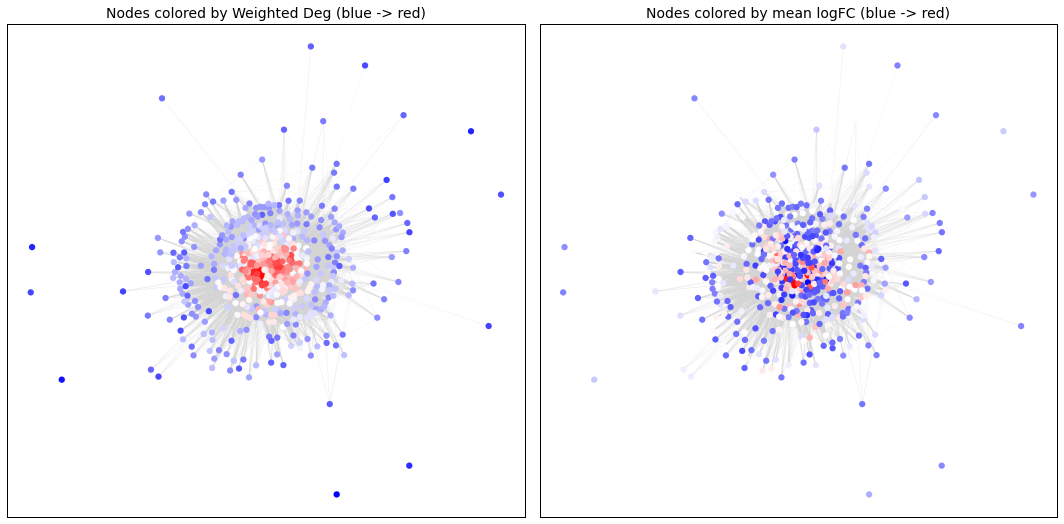

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,LI.M37.0,1.303928e-52,2.294913e-50,83/347,SIGLEC5;HP;CCR9;HK3;PRRG4;CYP4F3;GPR84;KCNJ15;...,immune activation - generic cluster,immune
1,DC.M4.15,2.255621e-41,1.984947e-39,32/42,CD247;BIN1;RASGRP1;PLEKHA1;ZNF831;CD7;LY9;PRKC...,T cells,DC.M4
2,LI.M7.0,1.129584e-39,6.626896e-38,36/62,CD247;RASGRP1;ICOS;CD7;SAMD3;PRKCH;ITM2A;NELL2...,enriched in T cells (I),immune
3,DC.M3.4,1.891672e-34,8.323357e-33,31/53,IRF7;TIMM10;IFIH1;PLSCR1;FBXO6;IFI35;GBP1;SCO2...,Interferon,DC.M3
4,LI.M7.1,3.798855e-32,1.337197e-30,29/50,CD247;RASGRP1;ICOS;CD7;PRKCH;THEMIS;CD5;EOMES;...,T cell activation (I),immune
5,DC.M3.2,5.502852e-28,1.614170e-26,39/138,SIGLEC5;CYP4F3;KCNJ15;ACSL1;TIMP2;ROPN1L;ITGAM...,Inflammation,DC.M3
6,LI.M11.0,1.473634e-27,3.705136e-26,44/189,TLR2;MYOF;HK3;ASGR2;FCER1G;LMO2;GRN;TIMP2;ITGA...,enriched in monocytes (II),immune
7,DC.M4.1,1.511011e-26,3.324223e-25,27/58,STMN3;NSG1;ICOS;ID3;TNFRSF25;NELL2;TRAT1;GPR18...,T cell,DC.M4
8,DC.M4.2,2.922577e-26,5.715262e-25,25/48,CASP5;LMNB1;MAPK14;SLPI;SIPA1L2;SOCS3;S100A12;...,Inflammation,DC.M4
9,LI.M7.4,8.051571e-19,1.417077e-17,13/15,RORA;ETS1;LCK;NELL2;RASGRP1;CAMK4;LEF1;ATP8B2;...,T cell activation (III),immune


---------------------------------------------




Edge Weight Threshold = 0.4375
Number of Nodes = 357
---------------------------------------------


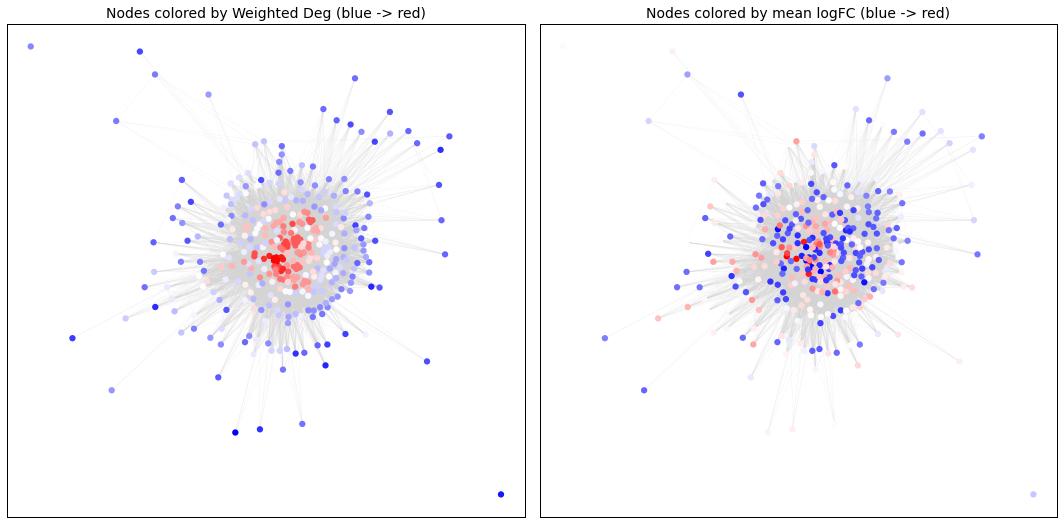

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,LI.M37.0,1.636506e-41,2.422029e-39,61/347,SIGLEC5;HP;HK3;KCNJ15;ACSL1;DYSF;SLPI;ROPN1L;M...,immune activation - generic cluster,immune
1,DC.M4.15,5.369488e-41,3.973421e-39,29/42,CD247;BIN1;RASGRP1;PLEKHA1;ZNF831;PRKCH;LY9;IT...,T cells,DC.M4
2,LI.M7.0,3.637493e-39,1.794497e-37,32/62,CD247;RASGRP1;ICOS;PRKCH;SAMD3;ITM2A;NELL2;UBA...,enriched in T cells (I),immune
3,DC.M3.4,8.975086e-35,3.320782e-33,28/53,IRF7;TIMM10;IFIH1;FBXO6;IFI35;GBP1;SCO2;ZBP1;T...,Interferon,DC.M3
4,LI.M7.1,2.374757e-30,7.029280e-29,25/50,CD247;RASGRP1;ICOS;PRKCH;CD5;EOMES;CD2;CD27;RH...,T cell activation (I),immune
5,LI.M11.0,8.099006e-25,1.997755e-23,35/189,TLR2;MYOF;HK3;ASGR2;FCER1G;GRN;EPB41L3;CYP1B1;...,enriched in monocytes (II),immune
6,DC.M4.1,1.614714e-23,3.413967e-22,22/58,STMN3;ICOS;ID3;NELL2;GPR183;LRRN3;SPOCK2;KLHL3...,T cell,DC.M4
7,DC.M4.2,1.758393e-22,3.253026e-21,20/48,IL18RAP;OSM;CASP5;KREMEN1;ANXA3;LMNB1;CYSTM1;S...,Inflammation,DC.M4
8,DC.M3.2,6.533568e-19,1.005464e-17,26/138,SIGLEC5;KCNJ15;ACSL1;ROPN1L;RGL4;CREB5;QPCT;SO...,Inflammation,DC.M3
9,LI.M7.4,6.793675e-19,1.005464e-17,12/15,RORA;ETS1;LCK;NELL2;RASGRP1;CAMK4;LEF1;ATP8B2;...,T cell activation (III),immune


---------------------------------------------




Edge Weight Threshold = 0.5
Number of Nodes = 239
---------------------------------------------


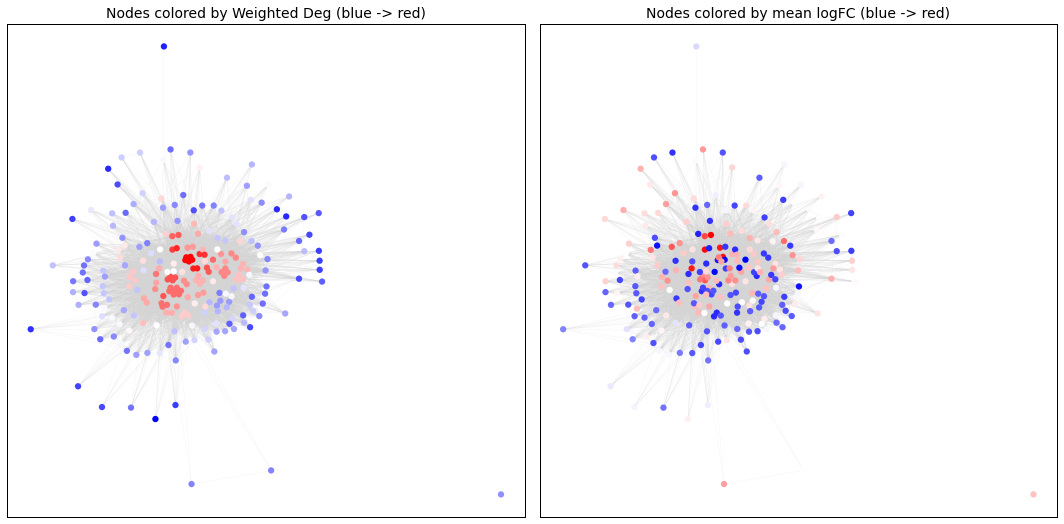

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,LI.M7.0,2.767099e-37,3.652570e-35,28/62,CD247;RASGRP1;ICOS;PRKCH;SAMD3;ITM2A;NELL2;EOM...,enriched in T cells (I),immune
1,DC.M3.4,6.639722e-36,4.382217e-34,26/53,TIMM10;IFIH1;FBXO6;IFI35;GBP1;SCO2;ZBP1;TRIM22...,Interferon,DC.M3
2,DC.M4.15,2.088178e-35,9.187981e-34,24/42,CD247;BIN1;RASGRP1;PLEKHA1;PRKCH;LY9;ITM2A;KLF...,T cells,DC.M4
3,LI.M37.0,2.776968e-30,9.163995e-29,43/347,SIGLEC5;HP;HK3;KCNJ15;ROPN1L;MCTP1;CREB5;CLEC1...,immune activation - generic cluster,immune
4,LI.M7.1,1.422442e-25,3.755247e-24,20/50,CD247;RORA;ITK;CD8A;EOMES;CD3D;RASGRP1;CCR7;CD...,T cell activation (I),immune
5,DC.M4.1,3.360488e-19,7.393073e-18,17/58,GPR183;ABLIM1;BACH2;CCR7;LRRN3;SPOCK2;LEF1;IL7...,T cell,DC.M4
6,LI.M11.0,1.356368e-18,2.557722e-17,25/189,MYOF;HK3;ASGR2;FCER1G;GRN;EPB41L3;RAB32;IFI30;...,enriched in monocytes (II),immune
7,LI.M7.2,7.519638e-16,1.240740e-14,14/49,CD247;RORA;ITK;IL2RB;EOMES;PLEKHF1;GNLY;ZAP70;...,enriched in NK cells (I),immune
8,DC.M4.2,1.809507e-14,2.653943e-13,13/48,OSM;CASP5;KREMEN1;ANXA3;S100A12;CLEC4D;LRG1;TL...,Inflammation,DC.M4
9,LI.M7.4,3.118173e-14,4.115989e-13,9/15,RORA;ETS1;NELL2;RASGRP1;LEF1;ATP8B2;KLF12;CD96...,T cell activation (III),immune


---------------------------------------------




Edge Weight Threshold = 0.5625
Number of Nodes = 149
---------------------------------------------


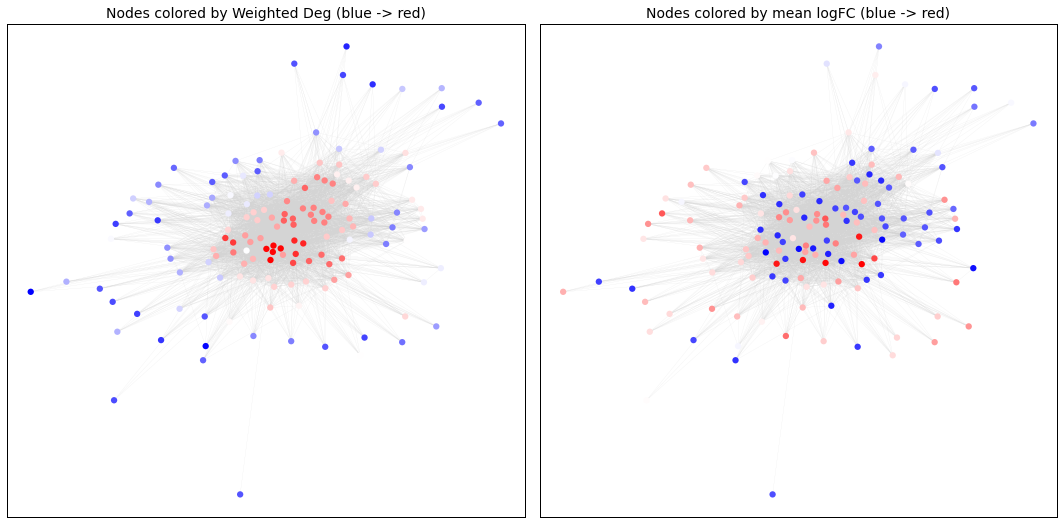

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,DC.M3.4,3.457347e-31,3.872228e-29,21/53,TIMM10;FBXO6;IFI35;GBP1;SCO2;ZBP1;TRIM22;PARP1...,Interferon,DC.M3
1,LI.M7.0,9.328978e-26,5.224228e-24,19/62,CD247;GZMK;ITK;ETS1;EOMES;CD2;IL7R;LEF1;CD27;I...,enriched in T cells (I),immune
2,DC.M4.15,1.210567e-23,4.519450e-22,16/42,CD247;GZMK;ITK;LBH;DYRK2;CD2;PLEKHA1;CD27;SH2D...,T cells,DC.M4
3,LI.M37.0,1.006675e-21,2.818689e-20,29/347,SIGLEC5;HP;HK3;KCNJ15;MCTP1;CREB5;RAB32;CD2;CE...,immune activation - generic cluster,immune
4,LI.M7.1,6.703090e-17,1.501492e-15,13/50,CD247;ITK;EOMES;CCR7;CD2;IL7R;LEF1;CD27;ICOS;Z...,T cell activation (I),immune
5,DC.M4.1,5.651294e-16,1.054908e-14,13/58,GPR183;ABLIM1;CCR7;LRRN3;SPOCK2;LEF1;IL7R;ICOS...,T cell,DC.M4
6,LI.M18,9.282584e-11,1.485213e-09,6/11,ITK;ETS1;ABLIM1;SPOCK2;SH2D1A;PRKCH,T cell differentiation via ITK and PKC,immune
7,LI.M11.0,2.801694e-10,3.922372e-09,14/189,HPSE;MYOF;HK3;RAB32;ASGR2;SORT1;S100A12;CRISPL...,enriched in monocytes (II),immune
8,DC.M4.2,3.370137e-09,4.193948e-08,8/48,ANXA3;KREMEN1;S100A12;LRG1;TLR5;MMP9;CA4;SIPA1L2,Inflammation,DC.M4
9,LI.M7.2,4.001241e-09,4.481390e-08,8/49,CD247;ITK;EOMES;ZAP70;TGFBR3;PRKCH;CD96;KLRB1,enriched in NK cells (I),immune


---------------------------------------------




Edge Weight Threshold = 0.625
Number of Nodes = 95
---------------------------------------------


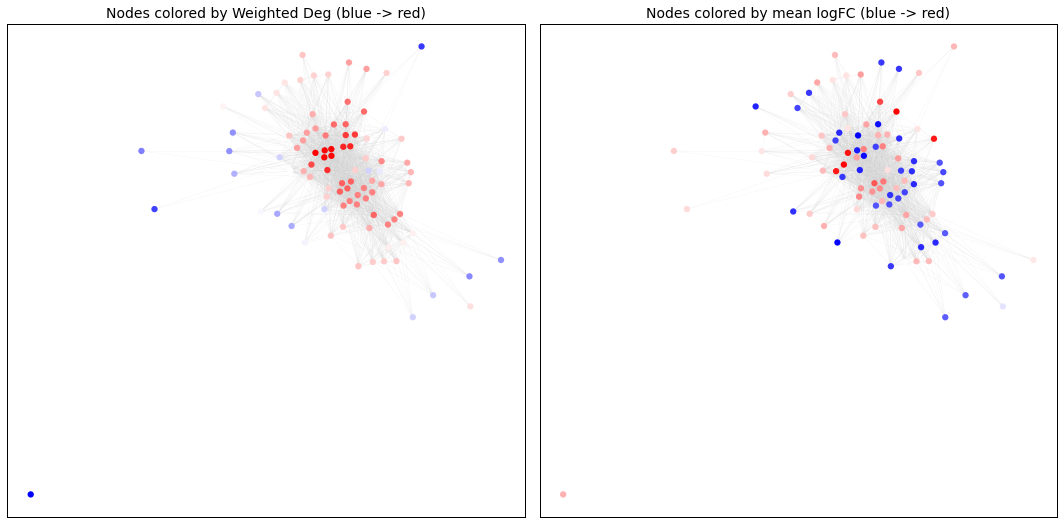

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,DC.M3.4,4.474711e-21,4.295723e-19,14/53,FBXO6;IFI35;TNFSF10;GBP1;SCO2;AIM2;TRIM22;TIMM...,Interferon,DC.M3
1,DC.M4.15,1.146106e-20,5.501309e-19,13/42,CD247;GZMK;ITK;LBH;DYRK2;PLEKHA1;CD27;SH2D1A;S...,T cells,DC.M4
2,LI.M7.0,5.221932e-20,1.671018e-18,14/62,CD247;GZMK;ITK;ETS1;IL7R;LEF1;CD27;SH2D1A;PRKC...,enriched in T cells (I),immune
3,DC.M4.1,2.518156e-13,6.043574e-12,10/58,GPR183;ABLIM1;CCR7;SPOCK2;LEF1;IL7R;ID3;BCL11B...,T cell,DC.M4
4,LI.M37.0,1.289879e-12,2.476568e-11,17/347,SIGLEC5;HK3;KCNJ15;CEACAM1;CAMP;SH2D1A;CRISPLD...,immune activation - generic cluster,immune
5,LI.M7.1,2.752476e-12,4.403962e-11,9/50,CD247;ITK;CCR7;IL7R;LEF1;CD27;PRKCH;ITPR3;BCL11B,T cell activation (I),immune
6,LI.M18,5.950212e-12,8.160290e-11,6/11,ITK;ETS1;ABLIM1;SPOCK2;SH2D1A;PRKCH,T cell differentiation via ITK and PKC,immune
7,LI.M11.0,2.603533e-09,3.124239e-08,11/189,MYOF;HK3;ASGR2;S100A12;CRISPLD2;ASGR1;FCGR1A;P...,enriched in monocytes (II),immune
8,LI.M117,5.309686e-08,5.663665e-07,5/21,SPOCK2;LEF1;CD6;CD96;NELL2,cell adhesion (GO),molecular function
9,LI.M14,2.791251e-07,2.679601e-06,4/12,SPOCK2;ITK;BCL11B;SH2D1A,T cell differentiation,immune


---------------------------------------------




Edge Weight Threshold = 0.6875
Number of Nodes = 63
---------------------------------------------


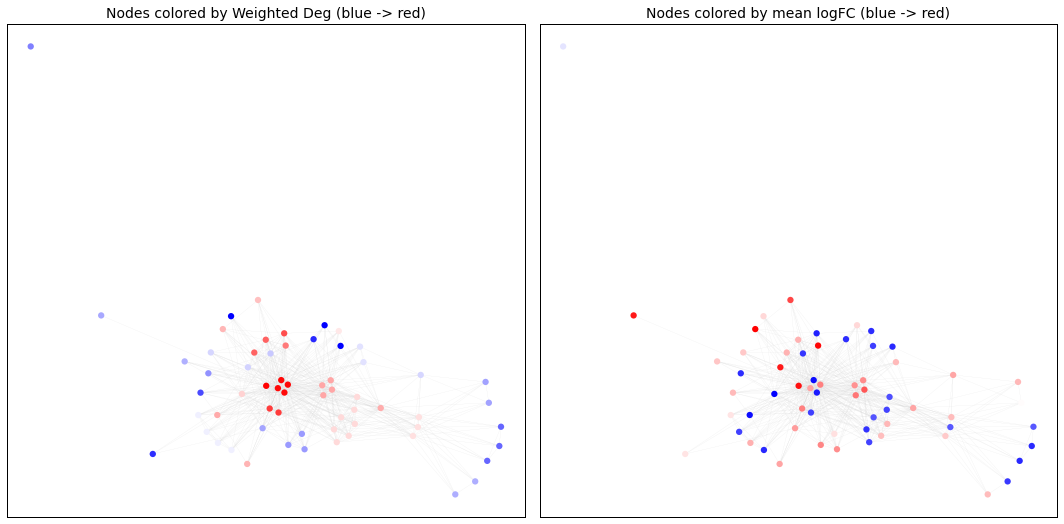

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,DC.M3.4,1.417657e-17,1.148302e-15,11/53,FBXO6;IFI35;GBP1;SCO2;AIM2;WARS;CEACAM1;LAP3;G...,Interferon,DC.M3
1,DC.M4.15,1.006795e-16,2.718346e-15,10/42,CD247;GZMK;ITK;LBH;PLEKHA1;CD27;S1PR1;SKAP1;CD...,T cells,DC.M4
2,LI.M7.0,9.241869e-17,2.718346e-15,11/62,CD247;GZMK;ITK;ETS1;LEF1;IL7R;CD27;CD6;CD96;BC...,enriched in T cells (I),immune
3,LI.M7.1,2.750263e-10,5.569283e-09,7/50,CD247;ITK;CCR7;IL7R;LEF1;CD27;BCL11B,T cell activation (I),immune
4,DC.M4.1,8.109885e-10,1.313801e-08,7/58,GPR183;ABLIM1;CCR7;SPOCK2;LEF1;IL7R;BCL11B,T cell,DC.M4
5,LI.M18,3.528252e-08,4.763141e-07,4/11,SPOCK2;ITK;ETS1;ABLIM1,T cell differentiation via ITK and PKC,immune
6,LI.M117,6.242178e-07,7.223091e-06,4/21,CD6;CD96;SPOCK2;LEF1,cell adhesion (GO),molecular function
7,DC.M1.2,1.803383e-06,1.825926e-05,4/27,SERPING1;IFITM3;BATF2;IFIT3,Interferon,DC.M1
8,LI.M14,7.434272e-06,6.690845e-05,3/12,SPOCK2;ITK;BCL11B,T cell differentiation,immune
9,LI.M65,1.224233e-05,9.916283e-05,3/14,CCR7;ITK;IL7R,"IL2, IL7, TCR network",immune


---------------------------------------------




Edge Weight Threshold = 0.75
Number of Nodes = 28
---------------------------------------------


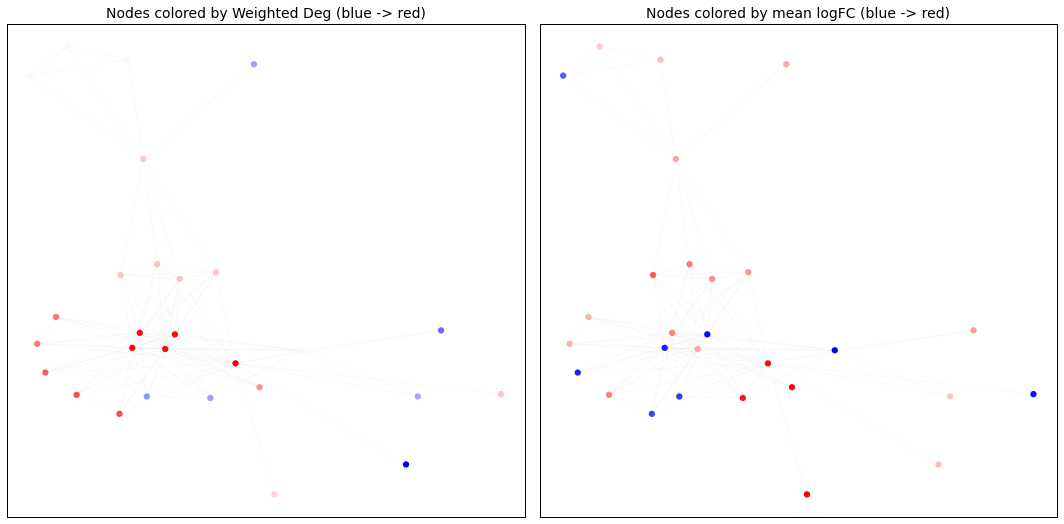

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,DC.M3.4,9.706505e-13,4.464992e-11,7/53,FBXO6;GBP1;SCO2;AIM2;CEACAM1;TNFAIP6;GBP5,Interferon,DC.M3
1,DC.M4.1,2.047834e-08,4.710019e-07,5/58,GPR183;ABLIM1;CCR7;SPOCK2;IL7R,T cell,DC.M4
2,LI.M16,4.143565e-05,6.353466e-04,3/46,DYSF;FCGR1A;FCGR1B,TLR and inflammatory signaling,immune


---------------------------------------------




Edge Weight Threshold = 0.8125
Number of Nodes = 8
---------------------------------------------


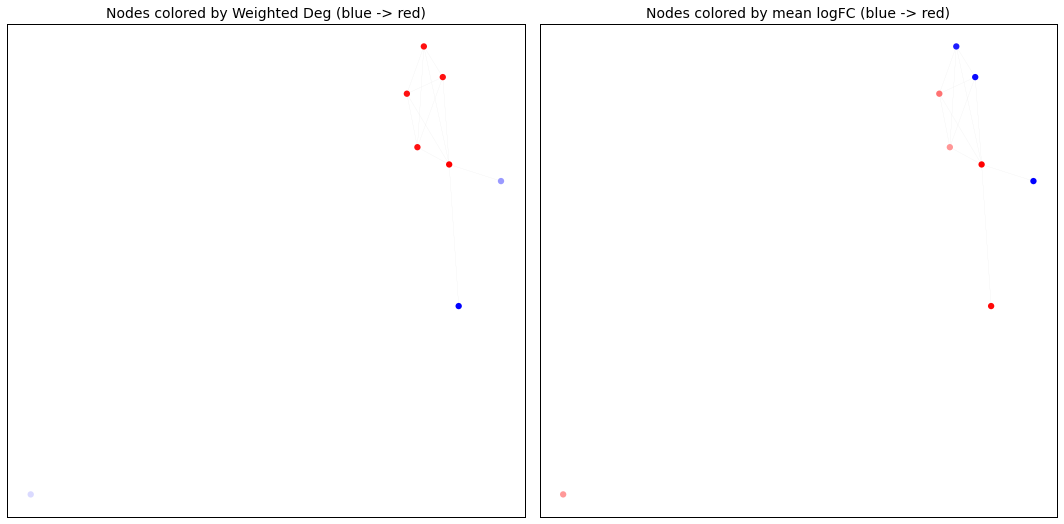

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category
0,DC.M4.1,0.000001,0.000031,3/58,CCR7;IL7R;GPR183,T cell,DC.M4
1,LI.M65,0.000014,0.000147,2/14,CCR7;IL7R,"IL2, IL7, TCR network",immune
2,LI.M16,0.000158,0.000983,2/46,FCGR1B;FCGR1A,TLR and inflammatory signaling,immune
3,LI.M7.1,0.000187,0.000983,2/50,CCR7;IL7R,T cell activation (I),immune


---------------------------------------------


In [68]:
for edge_weight_thresh in edge_weight_thresholds:
    
    subgraph_visualize_and_gene_enrichment(edge_weight_thresh)